# **Penting**
- Pastikan Anda melakukan Run All sebelum mengirimkan submission untuk memastikan seluruh cell berjalan dengan baik.
- Hapus simbol pagar (#) jika Anda menerapkan kriteria tambahan
- Biarkan simbol pagar (#) jika Anda tidak menerapkan kriteria tambahan

# **1. Import Library**
Mengimpor beberapa pustaka (library) Python yang dibutuhkan untuk analisis data dan pembangunan model machine learning.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import xgboost as xgb

from xgboost import plot_importance
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import joblib

# **2. Memuat Dataset**
Memuat dataset hasil clustering dari file CSV ke dalam variabel DataFrame.

In [2]:
url = "https://raw.githubusercontent.com/sirly82/predictive-analytics/refs/heads/main/diabetes.csv"
diabetes_df = pd.read_csv(url)

Menampilkan 5 data teratas

In [3]:
diabetes_df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


**Insight:** Dataset memiliki kolom-kolom seperti Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, DiabetesPedigreeFunction, Age, dan Outcome.

Menampilkan informasi detail dari dataset

In [4]:
diabetes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


**Insight:**
- Dataset terdiri dari 768 baris dan 9 kolom
- Semua fitur bertipe numerik
- Tidak ada nilai null terdeteksi

Menampilkan describsi dari dataset

In [5]:
diabetes_df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


**Insight:**

- Terdapat nilai minimum 0 pada fitur seperti Glucose, BloodPressure, SkinThickness, dan Insulin, yang secara medis tidak masuk akal.
- Rata-rata BMI cukup tinggi (~32), menunjukkan bahwa obesitas umum dalam dataset ini.

Memuat Dataset dan Melakukan Exploratory Data Analysis (EDA)

Menampilkan korelasi antar fitur

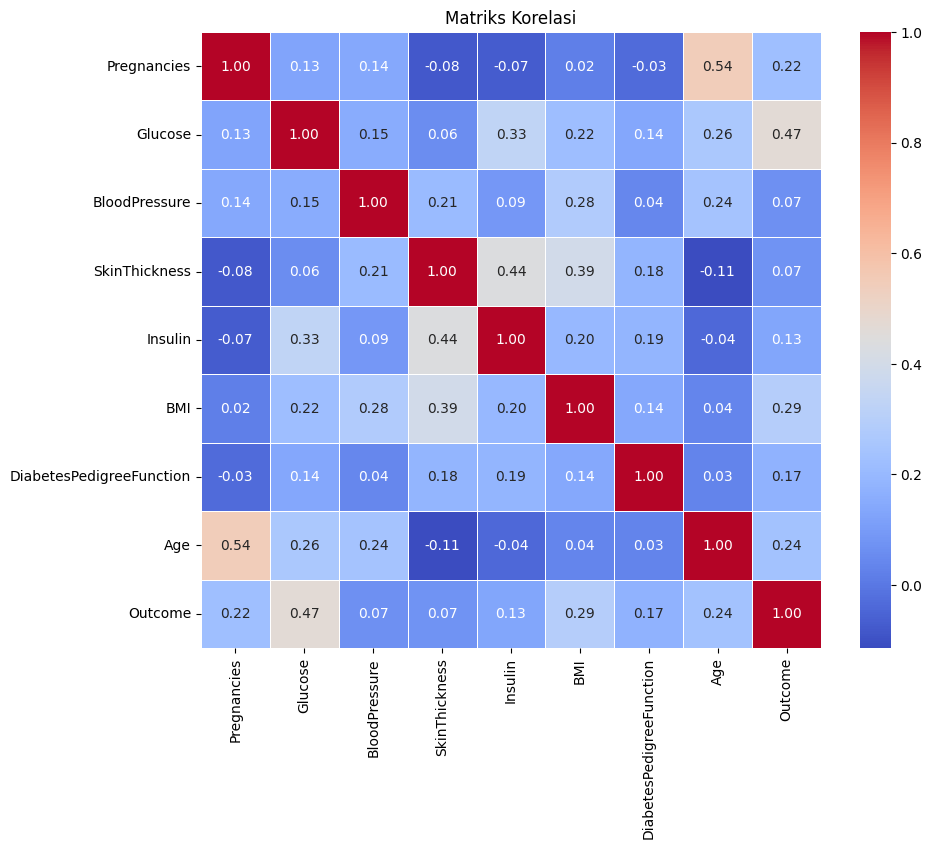

In [6]:
corr_matrix = diabetes_df.corr(numeric_only=True)

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Matriks Korelasi')
plt.show()

**Insight:** Fitur Glucose memiliki korelasi paling kuat dengan target Outcome (~0.47)

In [7]:
def plot_numeric_histograms(df):
  sns.set(style="whitegrid")

  num_cols = df.select_dtypes(include='number').columns

  total_plots = len(num_cols)
  n_cols = 3
  n_rows = math.ceil(total_plots / n_cols)

  fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5 * n_rows))
  axes = axes.flatten()

  for i, col in enumerate(num_cols):
    ax = axes[i]
    if col in num_cols:
      sns.histplot(data=df, x=col, bins=30, kde=True, ax=ax, color='skyblue')
      ax.set_title(f'Histogram: {col}', fontsize=12)
    else:
      unique_vals = df[col].nunique()
      if unique_vals <= 10:
        sns.countplot(data=df, x=col, order=df[col].value_counts().index, ax=ax, palette="Set2")
        ax.set_title(f'Countplot: {col}', fontsize=12)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
      else:
        sns.countplot(data=df, y=col, order=df[col].value_counts().index[:15], ax=ax, palette="Set3")
        ax.set_title(f'Top 15: {col}', fontsize=12)

    ax.grid(True)

  for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

  fig.suptitle("Distribusi Setiap Kolom", fontsize=16)
  plt.tight_layout(rect=[0, 0, 1, 0.97])
  plt.show()

Menampilkan histogram untuk semua kolom numerik

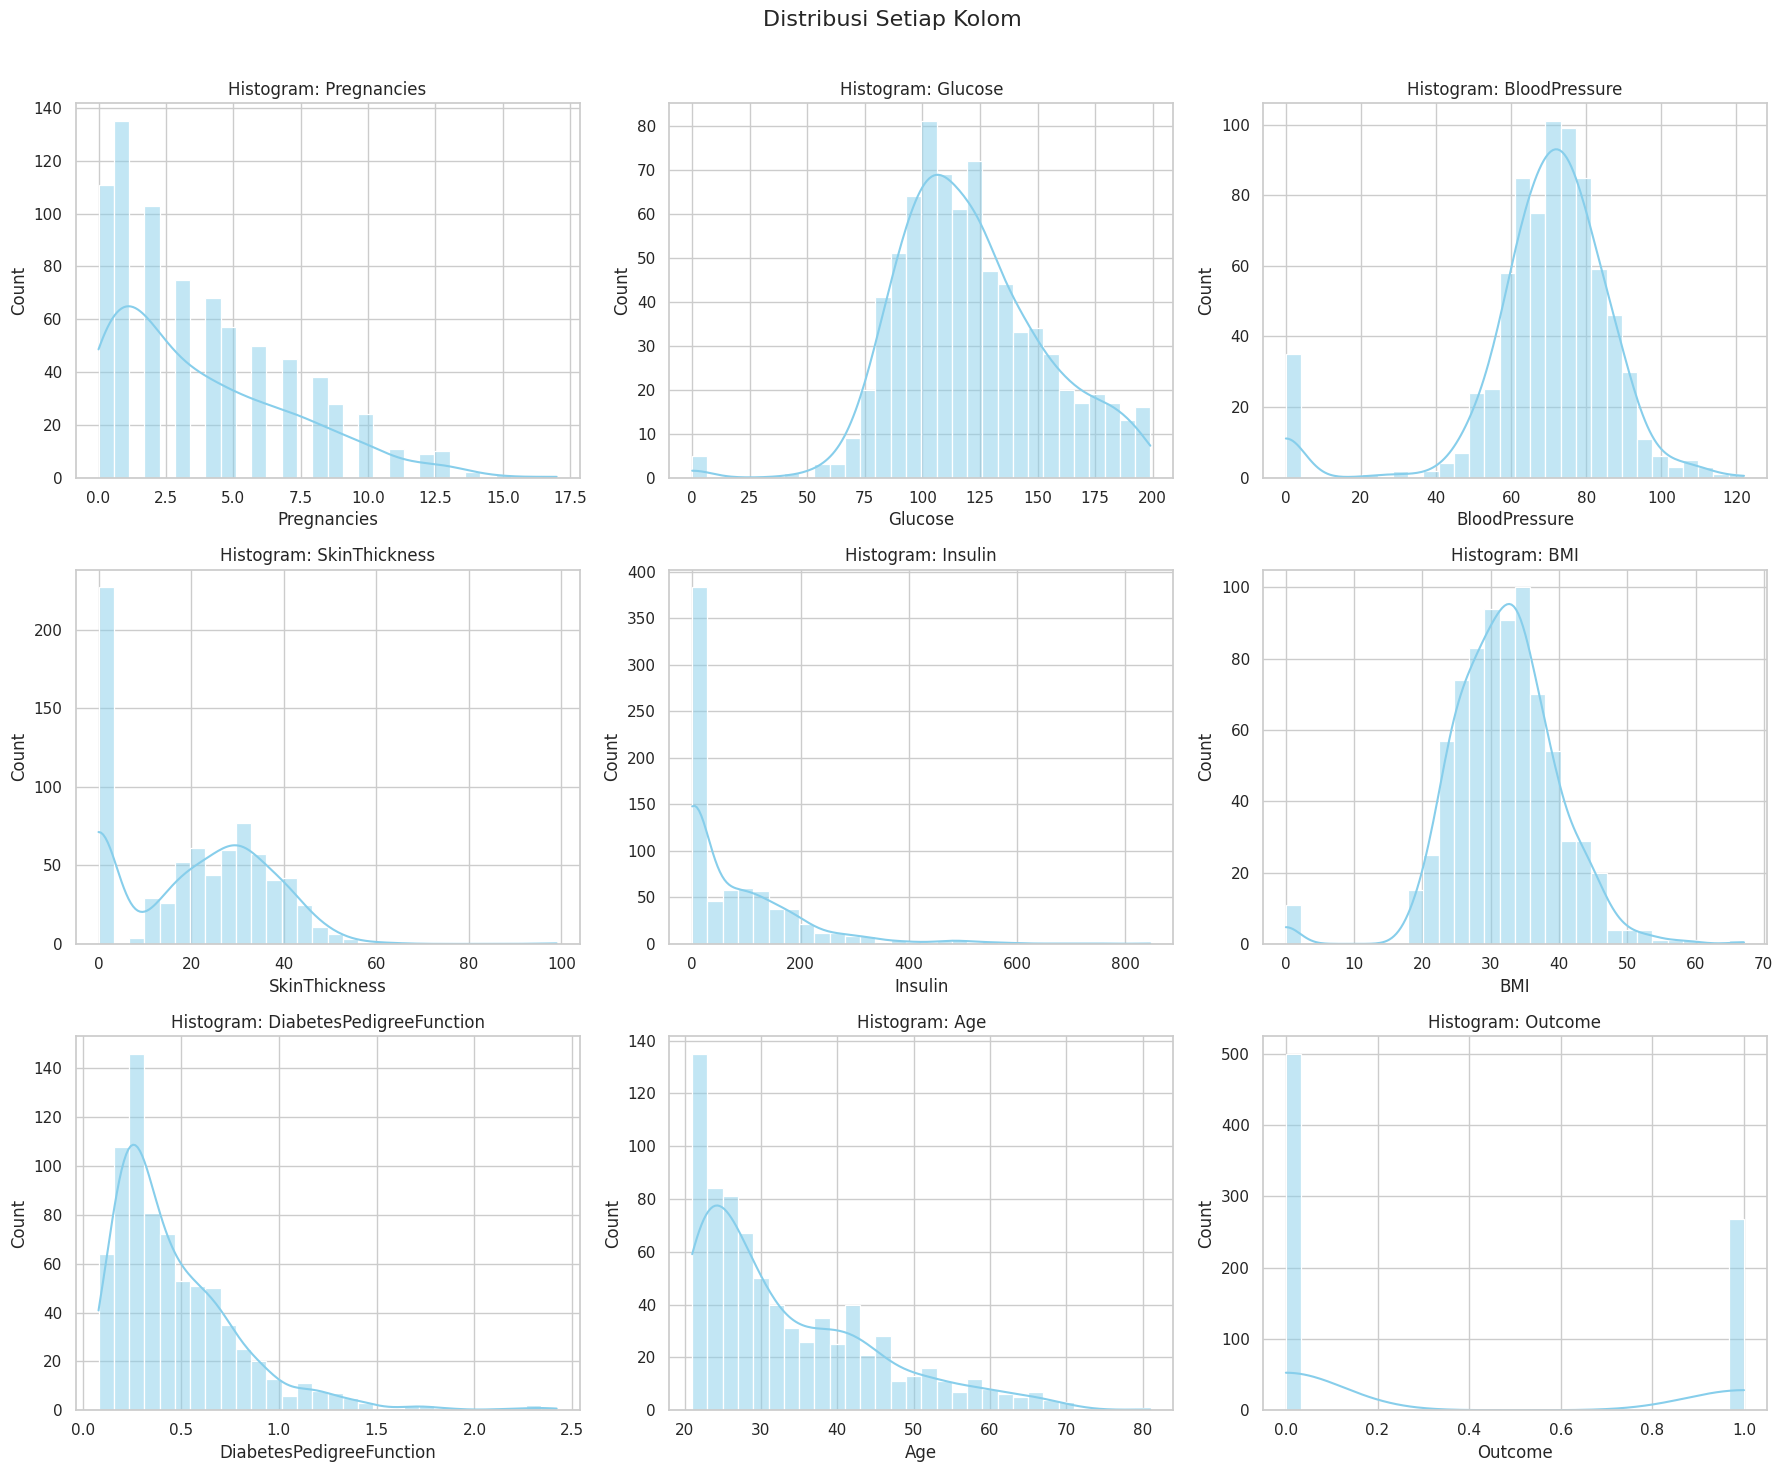

In [8]:
plot_numeric_histograms(diabetes_df)

# **3. Pembersihan dan Pra Pemrosesan Data**

Membuat copy dataset diabetes_clean_df

In [9]:
diabetes_clean_df = diabetes_df.copy()

Mengecek dataset menggunakan isnull().sum()

In [10]:
diabetes_clean_df.isnull().sum()

,0
Pregnancies,0
Glucose,0
BloodPressure,0
SkinThickness,0
Insulin,0
BMI,0
DiabetesPedigreeFunction,0
Age,0
Outcome,0


Mengecek duplikasi pada dataset menggunakan duplicated().sum()

In [11]:
duplicates = diabetes_clean_df.duplicated()
print("Jumlah baris duplikat:", duplicates.sum())

Jumlah baris duplikat: 0


**Insight:** Tidak ada baris data yang duplikat

Mengganti nilai 0 menjadi NaN pada kolom yang tidak mungkin bernilai 0, kemudian mengisi nilai NaN dengan nilai median

In [12]:
cols_with_zero = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
diabetes_df[cols_with_zero] = diabetes_df[cols_with_zero].replace(0, np.nan)

diabetes_df.fillna(diabetes_df.median(), inplace=True)

**Insight:**

- Nilai 0 pada kolom-kolom seperti Glucose, BMI, BloodPressure, dll tidak valid secara medis sehingga perlu ditangani sebagai missing value
- Mengganti 0 dengan NaN adalah cara untuk menandai nilai yang tidak logis.
- Mengisi nilai NaN dengan nilai median karena lebih tahan terhadap outlier dibandingkan mean

# **3. Data Splitting**
Tahap Data Splitting bertujuan untuk memisahkan dataset menjadi dua bagian: data latih (training set) dan data uji (test set).

In [13]:
scaler = StandardScaler()
X = diabetes_df.drop('Outcome', axis=1)
y = diabetes_df['Outcome']

X_scaled = scaler.fit_transform(X)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

**Insight:**

- Standarisasi fitur untuk meningkatkan performa dan stabilitas model
- Memisahkan data uji sebelum training penting agar evaluasi model tidak bias
- Proporsi 80:20 adalah standar umum dalam pemodelan, cukup untuk melatih dan mengevaluasi secara adil

# **4. Membangun Model Klasifikasi**
Setelah memilih algoritma klasifikasi yang sesuai, langkah selanjutnya adalah melatih model menggunakan data latih.

Berikut adalah rekomendasi tahapannya.
1. Menggunakan algoritma klasifikasi yaitu Logistic Regression
2. Latih model menggunakan data yang sudah dipisah.

## Logistic Regression

Membuat model Logistic Regression

In [15]:
model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)

LogisticRegression()

Menampilkan report classification dan akurasi

In [39]:
y_pred_lr = model_lr.predict(X_test)

print(classification_report(y_test, y_pred_lr))
print("Accuracy:", accuracy_score(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       0.80      0.83      0.81        99
           1       0.67      0.62      0.64        55

    accuracy                           0.75       154
   macro avg       0.73      0.72      0.73       154
weighted avg       0.75      0.75      0.75       154

Accuracy: 0.7532467532467533


**Insight:**

- Precision
  - Kelas 0 (0.80): Dari semua yang diprediksi sebagai non-diabetes, 80% benar-benar non-diabetes
  - Kelas 1 (0.67): Dari semua yang diprediksi sebagai diabetes, hanya 67% benar-benar diabetes. Ada kesalahan dalam memprediksi diabetes (false positive cukup tinggi)

- Recall
  - Kelas 0 (0.83): Dari seluruh non-diabetes, 83% berhasil dikenali dengan benar
  - Kelas 1 (0.62): Dari seluruh pasien diabetes, hanya 62% yang berhasil dikenali. Ada cukup banyak penderita diabetes yang tidak terdeteksi (false negative tinggi)

- F1-Score merupakan rata-rata antara precision dan recall
  - Kelas 0: 0.81
  - Kelas 1: 0.64

  Untuk melihat keseimbangan performa, terutama jika distribusi data tidak seimbang

- Support menunjukkan jumlah aktual dari setiap kelas dalam data uji:
  - Kelas 0: 99 orang
  - Kelas 1: 55 orang

Menampilkan Confusion Matrix dari Logistic Linear

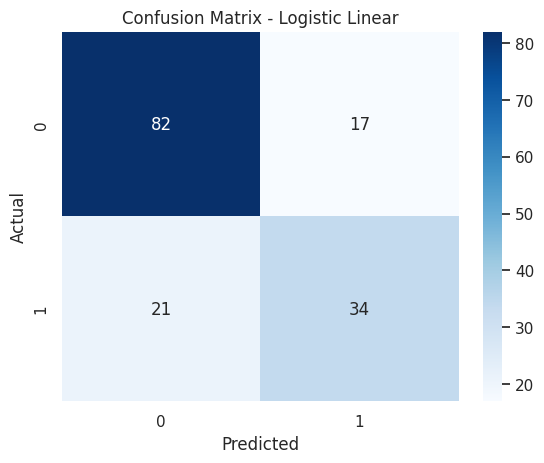

In [17]:
cm = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Linear")
plt.show()

**Insight:**

- 82 pasien non-diabetes diprediksi benar sebagai non-diabetes (true positive)
- 17 pasien non-diabetes salah diprediksi sebagai diabetes (false positive)
- 21 pasien diabetes tidak terdeteksi alias diprediksi sebagai non-diabetes (false negative)
- 34 pasien diabetes terdeteksi benar sebagai diabetes (true negative)

Menyimpan model logistic_regression

In [18]:
joblib.dump(model_lr, 'logistic_regression_model.h5')

['logistic_regression_model.h5']

## Random Forest

Membuat model Random Forest

In [19]:
model_rf = RandomForestClassifier(n_estimators=50, max_depth=16, random_state=55, n_jobs=-1)
model_rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=16, n_estimators=50, n_jobs=-1,
                       random_state=55)

Menampilkan report classification dan akurasi

In [38]:
y_pred_rf = model_rf.predict(X_test)

print(classification_report(y_test, y_pred_rf))
print("Accuracy:", accuracy_score(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.82      0.81      0.81        99
           1       0.66      0.67      0.67        55

    accuracy                           0.76       154
   macro avg       0.74      0.74      0.74       154
weighted avg       0.76      0.76      0.76       154

Accuracy: 0.7597402597402597


**Insight:**

- Precision
  - Kelas 0 (0.82): Dari semua yang diprediksi sebagai non-diabetes, 82% benar-benar non-diabetes
  - Kelas 1 (0.66): Dari semua yang diprediksi sebagai diabetes, hanya 66% benar-benar diabetes. Ada kesalahan dalam memprediksi diabetes (false positive cukup tinggi)

- Recall
  - Kelas 0 (0.81): Dari seluruh non-diabetes, 81% berhasil dikenali dengan benar
  - Kelas 1 (0.67): Dari seluruh pasien diabetes, hanya 67% yang berhasil dikenali. Ada cukup banyak penderita diabetes yang tidak terdeteksi (false negative tinggi)

- F1-Score merupakan rata-rata antara precision dan recall
  - Kelas 0: 0.81
  - Kelas 1: 0.67

  Untuk melihat keseimbangan performa, terutama jika distribusi data tidak seimbang

- Support menunjukkan jumlah aktual dari setiap kelas dalam data uji:
  - Kelas 0: 99 orang
  - Kelas 1: 55 orang

Menampilkan confussion Matrix dari Random Forest

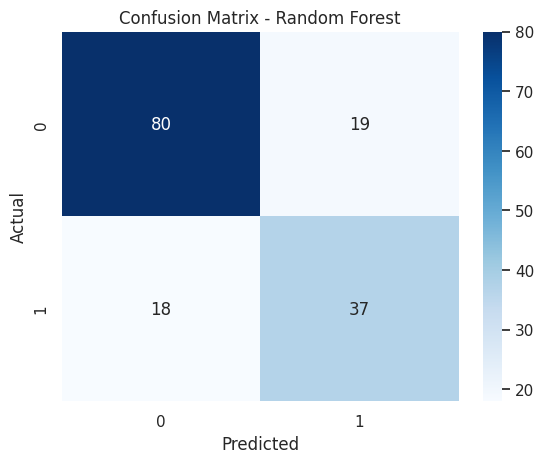

In [21]:
cm = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Random Forest")
plt.show()

**Insight:**

- 80 pasien non-diabetes diprediksi benar sebagai non-diabetes (true positive)
- 19 pasien non-diabetes salah diprediksi sebagai diabetes (false positive)
- 18 pasien diabetes tidak terdeteksi alias diprediksi sebagai non-diabetes (false negative)
- 37 pasien diabetes terdeteksi benar sebagai diabetes (true negative)

Menyimpan model random forest

In [22]:
joblib.dump(model_rf, 'explore_random_forest_classification.h5')

['explore_random_forest_classification.h5']

## Hyperparameter Tuning Model

Mendefinisikan grid dari hyperparameter yang akan diuji menggunakan GridSearchCV

In [23]:
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

**Insight:**
Menentukan berbagai kombinasi nilai hyperparameter untuk Random Forest agar bisa diuji coba dan dicari konfigurasi terbaik yang meningkatkan performa model

Membuat objek RandomForest dengan penyeimbangan bobot kelas (class_weight='balanced') untuk menangani data yang tidak seimbang

In [24]:
model_rf2 = RandomForestClassifier(random_state=42, class_weight='balanced')

**Insight:**
Pengaturan class_weight balance digunakan untuk mengatasi ketidakseimbangan data kelas diabetes dan non-diabetes sehingga model tidak bias terhadap kelas mayoritas

Melakukan pencarian grid (GridSearchCV) dengan 5-fold cross-validation untuk menemukan kombinasi parameter terbaik berdasarkan skor akurasi

In [25]:
grid_search = GridSearchCV(estimator=model_rf2, param_grid=param_grid,
                           cv=5, n_jobs=-1, scoring='accuracy', verbose=1)

**Insight:**
GridSearchCV dengan 5-fold CV dipakai untuk mengevaluasi berbagai kombinasi hyperparameter secara menyeluruh

Melatih model pada data latih

In [26]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [None, 3, 5, 10],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 150]},
             scoring='accuracy', verbose=1)

Menampilkan kombinasi parameter terbaik dan akurasi rata-rata cross-validation tertinggi

In [27]:
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Best parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 50}
Best score: 0.7785419165667067


**Insight:**
Model mampu memprediksi dengan benar sekitar 77.85% dari data pelatihan

Menggunakan model terbaik dari hasil GridSearchCV untuk prediksi pada data uji

In [28]:
model_best_rf = grid_search.best_estimator_
y_pred_best = model_best_rf.predict(X_test)

Menampilkan metrik evaluasi

In [29]:
print(classification_report(y_test, y_pred_best))
print("Final Accuracy with Best Params:", accuracy_score(y_test, y_pred_best))

              precision    recall  f1-score   support

           0       0.85      0.74      0.79        99
           1       0.62      0.76      0.68        55

    accuracy                           0.75       154
   macro avg       0.73      0.75      0.74       154
weighted avg       0.77      0.75      0.75       154

Final Accuracy with Best Params: 0.7467532467532467


**Insight:**

- Precision
  - Kelas 0 (0.85): Dari semua yang diprediksi sebagai non-diabetes, 85% benar-benar non-diabetes
  - Kelas 1 (0.62): Dari semua yang diprediksi sebagai diabetes, hanya 62% benar-benar diabetes. Ada kesalahan dalam memprediksi diabetes (false positive cukup tinggi)

- Recall
  - Kelas 0 (0.77): Dari seluruh non-diabetes, 77% berhasil dikenali dengan benar
  - Kelas 1 (0.76): Dari seluruh pasien diabetes, 76% berhasil dikenali. Ini sudah meningkat sedikit dari model sebelumnya

- F1-Score merupakan rata-rata antara precision dan recall
  - Kelas 0: 0.71
  - Kelas 1: 0.68

  Untuk melihat keseimbangan performa, terutama jika distribusi data tidak seimbang

- Support menunjukkan jumlah aktual dari setiap kelas dalam data uji:
  - Kelas 0: 99 orang
  - Kelas 1: 55 orang

Membuat visualisasi confusion matrix untuk memahami performa prediksi model

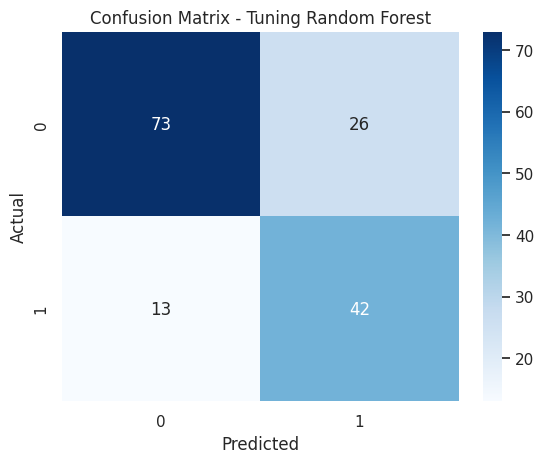

In [30]:
cm = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Tuning Random Forest")
plt.show()

**Insight:**

- 73 pasien non-diabetes diprediksi benar sebagai non-diabetes (true positive)
- 26 pasien non-diabetes salah diprediksi sebagai diabetes (false positive)
- 13 pasien diabetes tidak terdeteksi alias diprediksi sebagai non-diabetes (false negative)
- 42 pasien diabetes terdeteksi benar sebagai diabetes (true negative)

Menampilkan grafik dari pentingnya tiap fitur dalam prediksi menurut model Random Forest

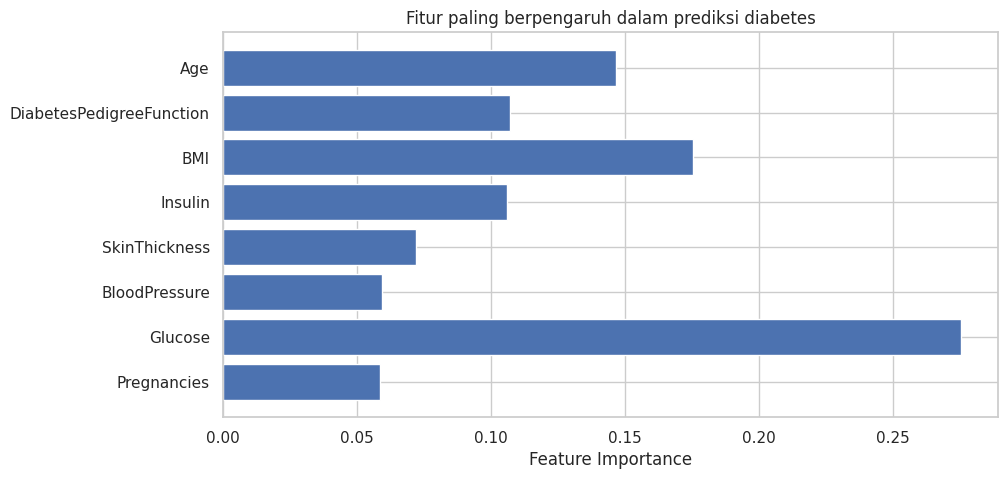

In [31]:
importances = model_best_rf.feature_importances_
feat_names = X.columns

plt.figure(figsize=(10,5))
plt.barh(feat_names, importances)
plt.xlabel("Feature Importance")
plt.title("Fitur paling berpengaruh dalam prediksi diabetes")
plt.show()

**Insight:**
3 fitur yang sangat mempengaruhi prediksi diabetes adalah glucose(+25%), BMI(+15%), dan age(~14%)

Menyimpan model terbaik Random Forest setelah melakukan tuning

In [32]:
joblib.dump(model_best_rf, 'tuning_classification_rf.h5')

['tuning_classification_rf.h5']

## Boosting Algoritma

Membuat dan melatih model XGBoost

In [33]:
model_boost = XGBClassifier(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

model_boost.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:31:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

Memprediksi dan mengevaluasi performa XGBoost

In [34]:
y_pred_boost = model_boost.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_boost))
print("\nClassification Report:\n", classification_report(y_test, y_pred_boost))

Accuracy: 0.7597402597402597

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.79      0.81        99
           1       0.65      0.71      0.68        55

    accuracy                           0.76       154
   macro avg       0.74      0.75      0.74       154
weighted avg       0.77      0.76      0.76       154


Confusion Matrix:
 [[78 21]
 [16 39]]


Visualisasi confusion matrix untuk model XGBoost

**Insight:**

- Precision
  - Kelas 0 (0.83): Dari semua yang diprediksi sebagai non-diabetes, 83% benar-benar non-diabetes
  - Kelas 1 (0.65): Dari semua yang diprediksi sebagai diabetes, hanya 65% benar-benar diabetes. Ada kesalahan dalam memprediksi diabetes (false positive cukup tinggi)

- Recall
  - Kelas 0 (0.79): Dari seluruh non-diabetes, 77% berhasil dikenali dengan benar
  - Kelas 1 (0.71): Dari seluruh pasien diabetes, hanya 71% berhasil dikenali

- F1-Score merupakan rata-rata antara precision dan recall
  - Kelas 0: 0.81
  - Kelas 1: 0.68

  Untuk melihat keseimbangan performa, terutama jika distribusi data tidak seimbang

- Support menunjukkan jumlah aktual dari setiap kelas dalam data uji:
  - Kelas 0: 99 orang
  - Kelas 1: 55 orang

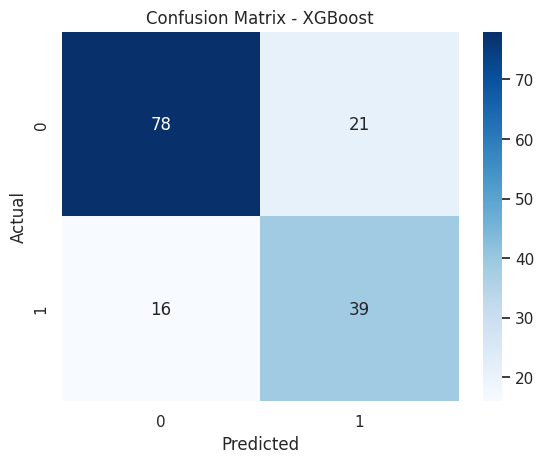

In [35]:
cm = confusion_matrix(y_test, y_pred_boost)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - XGBoost")
plt.show()

**Insight:**

- 78 pasien non-diabetes diprediksi benar sebagai non-diabetes (true positive)
- 21 pasien non-diabetes salah diprediksi sebagai diabetes (false positive)
- 16 pasien diabetes tidak terdeteksi alias diprediksi sebagai non-diabetes (false negative)
- 39 pasien diabetes terdeteksi benar sebagai diabetes (true negative)

Membuat DataFrame untuk membandingkan akurasi dan f1-score dari ketiga model

In [36]:
eval_df = pd.DataFrame(index=['accuracy', 'f1'], columns=['Logistic Regression', 'Random Forest', 'XGBoost'])

eval_df.loc['accuracy', 'Logistic Regression'] = accuracy_score(y_test, model_lr.predict(X_test))
eval_df.loc['f1', 'Logistic Regression'] = f1_score(y_test, model_lr.predict(X_test))

eval_df.loc['accuracy', 'Random Forest'] = accuracy_score(y_test, model_rf.predict(X_test))
eval_df.loc['f1', 'Random Forest'] = f1_score(y_test, model_rf.predict(X_test))

eval_df.loc['accuracy', 'XGBoost'] = accuracy_score(y_test, y_pred_boost)
eval_df.loc['f1', 'XGBoost'] = f1_score(y_test, y_pred_boost)

display(eval_df)

,Logistic Regression,Random Forest,XGBoost
accuracy,0.753247,0.75974,0.75974
f1,0.641509,0.666667,0.678261


**Insight:**

- Akurasi:
  - Ketiga model memiliki performa akurasi yang cukup mirip, yaitu sekitar 75-76%. Random Forest dan XGBoost sama-sama di angka ~75.97% yang sedikit lebih baik daripada Logistic Regression di 75.32%.
  - Random Forest dan XGBoost sedikit lebih baik dalam menangkap pola data dibandingkan Logistic Regression

- F1-Score:
  - F1-score lebih menggambarkan keseimbangan antara kesalahan positif dan negatif, penting untuk dataset dengan distribusi kelas yang tidak seimbang
  - XGBoost menunjukkan nilai F1-score tertinggi yaitu 0.68, diikuti oleh Random Forest 0.67, dan Logistic Regression 0.64.
  - Dengan begitu, dapat dikatakan XGBoost lebih baik dalam menangani kelas positif (pasien diabetes) dengan keseimbangan antara mengenali benar kasus positif dan menghindari false alarm, dibandingkan dua model lain

Menampilkan pentingnya fitur menurut model XGBoost

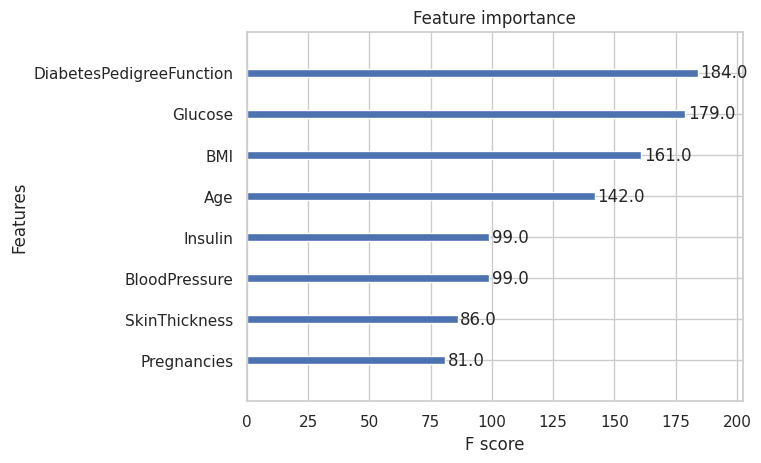

In [45]:
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=X.columns.tolist())
dtest = xgb.DMatrix(X_test, label=y_test, feature_names=X.columns.tolist())

params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'max_depth': 4,
    'learning_rate': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}

model_boost = xgb.train(params, dtrain, num_boost_round=100)

xgb.plot_importance(model_boost)
plt.show()

**Insight:**

- Feautures yang sangat mempengaruhi menurut XGBoost adalah:
  - DiabetesPedigreeFunction : 184.0
  - Glucose : 179.0
  - BMI : 161.0
  - Age : 142.0